In [0]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn, optim

In [0]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        #[b, 784]
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Linear(64, 20),
            nn.ReLU()
        )

        #[b, 20]
        self.decoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        :param x: [b, 1, 28, 28]
        :return: x
        """
        batch_size = x.size(0)
        #flatten
        x = x.view(batch_size, 784)
        #encoder
        x = self.encoder(x)
        #decoder
        x = self.decoder(x)
        #reshape
        x = x.view(batch_size, 1, 28, 28)

        return x


In [81]:
mnist_train1 = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]), download=True)

# 测试的时候务必关掉shuffle，不然会导致索引和原来的数据顺序不对应
mnist_train = DataLoader(mnist_train1, batch_size=32, shuffle=False)

mnist_test1 = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]), download=True)

mnist_test = DataLoader(mnist_test1, batch_size=32, shuffle=True)

x, _ = iter(mnist_train).next()
print("x:", x.shape)

x: torch.Size([32, 1, 28, 28])


In [4]:
# main

#设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#模型
model = AutoEncoder().to(device)
print(model)

#损失函数
criteon = nn.MSELoss()

#优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()

for epoch in range(100):

    for index, (x, _) in enumerate(mnist_train):
        # [b, 1, 28, 28]
        x = x.to(device)
        
        x_hat = model(x)
        loss = criteon(x_hat, x)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(epoch, "loss:", loss.item())


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=20, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
0 loss: 0.5454434156417847
1 loss: 0.49735572934150696
2 loss: 0.5517454743385315
3 loss: 0.5129666328430176
4 loss: 0.49252986907958984
5 loss: 0.5528095960617065
6 loss: 0.5181561708450317
7 loss: 0.5200440287590027
8 loss: 0.5277820229530334
9 loss: 0.502334713935852
10 loss: 0.5213916897773743
11 loss: 0.4811539947986603
12 loss: 0.5322343111038208
13 loss: 0.5048983097076416
14 loss: 0.4503076374530792
15 loss: 0.5152643918991089
16 loss: 0.5129572153091431
17 loss: 0.

# 自编码器训练结果：

- 奇数为原图，偶数为编码后的图

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

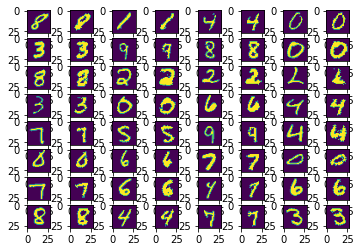

In [9]:
l, _ = iter(mnist_test).next()
for i in range(32):
    plt.subplot(8, 8, 2 * i + 1)
    x = l[i].type(torch.uint8)
    plt.imshow(Image.fromarray(x.squeeze().numpy().astype(np.uint8)))
    x = l[i].to(device)
    x = model(x).squeeze().to('cpu')
    plt.subplot(8, 8, 2 * i + 2)
    plt.imshow(Image.fromarray(x.squeeze().detach().numpy().astype(np.uint8)))


# 使用自编码器对原数据进行处理：


In [82]:
l = []
model.eval()
for index, (x, _) in enumerate(mnist_train):
    # [b, 1, 28, 28]
    l.append(model(x.to(device)))

total = None
for i in range(len(l)):
    if i == 0: 
        total = l[0]
    else:
        total = torch.cat((total, l[i]), 0)

print(total.shape)


torch.Size([60000, 1, 28, 28])


# 使用内积的方式度量距离：

In [89]:
# 内积度量

test_img, y = iter(mnist_test).next()
total = total.to('cpu')
res = torch.sum(total.view((60000, -1)).to(torch.float32) * test_img[0].view(784).to(torch.float32), axis=1)
print(res.shape)

val, idx = torch.topk(res, k=10)
print(idx)

torch.Size([60000])
tensor([25911, 49332, 39124, 53545, 59598, 54336, 35932, 18099, 28171, 17308])


原图：


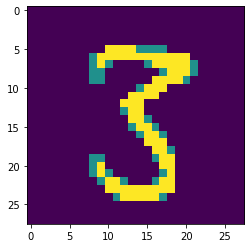

In [90]:
print("原图：")
plt.imshow(test_img[0].squeeze().numpy().astype(np.uint8))

最相近的10张图：


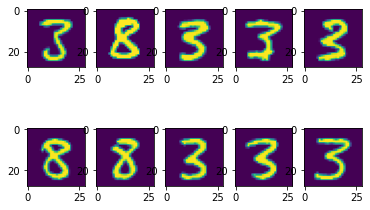

In [91]:
# print(mnist_train1.data.shape)
print("最相近的10张图：")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_train1.data[idx[i]].squeeze().numpy().astype(np.uint8))

# 使用余弦度量距离：


In [92]:
# 余弦度量
import torch.nn.functional as F
f1 = total.view(60000,-1)
f2 = test_img[0].view(1, -1)
f1 = F.normalize(f1)
f2 = F.normalize(f2)

res = f1.mm(f2.T).view(-1)
print(res.shape)

val, idx = torch.topk(res, k=10)
print(idx)

torch.Size([60000])
tensor([33917, 44440, 27362, 48666, 36377, 25911, 56288,  2926, 17966,  5270])


最相近的10张图：


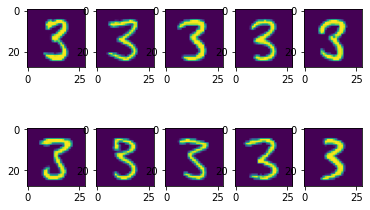

In [93]:
# print(mnist_train1.data.shape)
print("最相近的10张图：")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_train1.data[idx[i]].squeeze().numpy().astype(np.uint8))